In [1]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [2]:
from simulations.analysis.collect_bb_simulation_data_old2 import get_df_columns

get_df_columns()

['fail',
 'converge',
 'cluster_size_sum',
 'max_cluster_size',
 'cluster_num',
 'pred_bp_llr',
 'cluster_bp_llr_sum',
 'outside_cluster_bp_llr',
 'pred_llr',
 'cluster_llr_sum',
 'outside_cluster_llr']

In [4]:
from simulations.analysis.collect_bb_simulation_data import aggregate_data

ascending_confidences = {
    "cluster_frac": False,
    # "cluster_num": False,
    "total_boundary_size": False,
    "max_cluster_size": False,
    "max_cluster_llr": False,
    "max_cluster_bp_llr": False,
    "max_cluster_bp_llr_plus": False,
    "cluster_llr_gap": True,
    "cluster_llr_norm_gap": True,
    "cluster_bp_llr_gap": True,
    "cluster_bp_llr_plus_gap": True,
    "cluster_bp_llr_plus_norm_gap": True,
    "pred_llr": False,
    "pred_bp_llr": False,
    "detector_density": False,
}

df_agg_dict = {}
for by, ascending_confidence in ascending_confidences.items():
    print(
        f"\nAggregating data for {by} with ascending_confidence={ascending_confidence}..."
    )
    df_agg = aggregate_data(
        by=by,
        n=144,
        p=0.001,
        num_hist_bins=10000,
        ascending_confidence=ascending_confidence,
        verbose=False,
    )
    df_agg_dict[by] = df_agg
    print("=============")


Aggregating data for cluster_frac with ascending_confidence=False...


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]



Aggregating data for total_boundary_size with ascending_confidence=False...


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]



Aggregating data for max_cluster_size with ascending_confidence=False...


100%|██████████| 2/2 [00:01<00:00,  1.96it/s]



Aggregating data for max_cluster_llr with ascending_confidence=False...


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]



Aggregating data for max_cluster_bp_llr with ascending_confidence=False...


100%|██████████| 2/2 [00:01<00:00,  1.87it/s]



Aggregating data for max_cluster_bp_llr_plus with ascending_confidence=False...


100%|██████████| 2/2 [00:01<00:00,  1.60it/s]



Aggregating data for cluster_llr_gap with ascending_confidence=True...


100%|██████████| 2/2 [00:01<00:00,  1.29it/s]



Aggregating data for cluster_llr_norm_gap with ascending_confidence=True...


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]



Aggregating data for cluster_bp_llr_gap with ascending_confidence=True...


100%|██████████| 2/2 [00:01<00:00,  1.31it/s]



Aggregating data for cluster_bp_llr_plus_gap with ascending_confidence=True...


100%|██████████| 2/2 [00:01<00:00,  1.29it/s]



Aggregating data for cluster_bp_llr_plus_norm_gap with ascending_confidence=True...


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]



Aggregating data for pred_llr with ascending_confidence=False...


100%|██████████| 2/2 [00:01<00:00,  1.39it/s]



Aggregating data for pred_bp_llr with ascending_confidence=False...


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]



Aggregating data for detector_density with ascending_confidence=False...


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

In [5]:
from collect_bb_simulation_data import get_df_ps

df_ps_dict = {}
for by, df_agg in df_agg_dict.items():
    df_ps = get_df_ps(df_agg, ascending_confidence=ascending_confidences[by])
    df_ps_dict[by] = df_ps

In [6]:
def error_band_plot(data, x, y, delta_y, ax=None, color=None, alpha=0.3, **kwargs):
    """
    Plot a line with confidence interval.

    Parameters
    ----------
    data : pandas DataFrame
        DataFrame containing the data to plot
    x : str
        Column name for x-axis
    y : str
        Column name for y-axis
    delta_y : str
        Column name for confidence interval
    ax : matplotlib.axes.Axes
        Axes to plot on
    color : str or tuple
        Color for the line and confidence interval
    alpha : float, optional
        Alpha value for confidence interval, defaults to 0.3
    """
    if ax is None:
        ax = plt.gca()
    sns.lineplot(data=data, x=x, y=y, ax=ax, color=color, **kwargs)
    ax.fill_between(
        data[x],
        data[y] - data[delta_y],
        data[y] + data[delta_y],
        alpha=alpha,
        color=color,
    )

Text(0, 0.5, '$p_\\mathrm{fail}$')

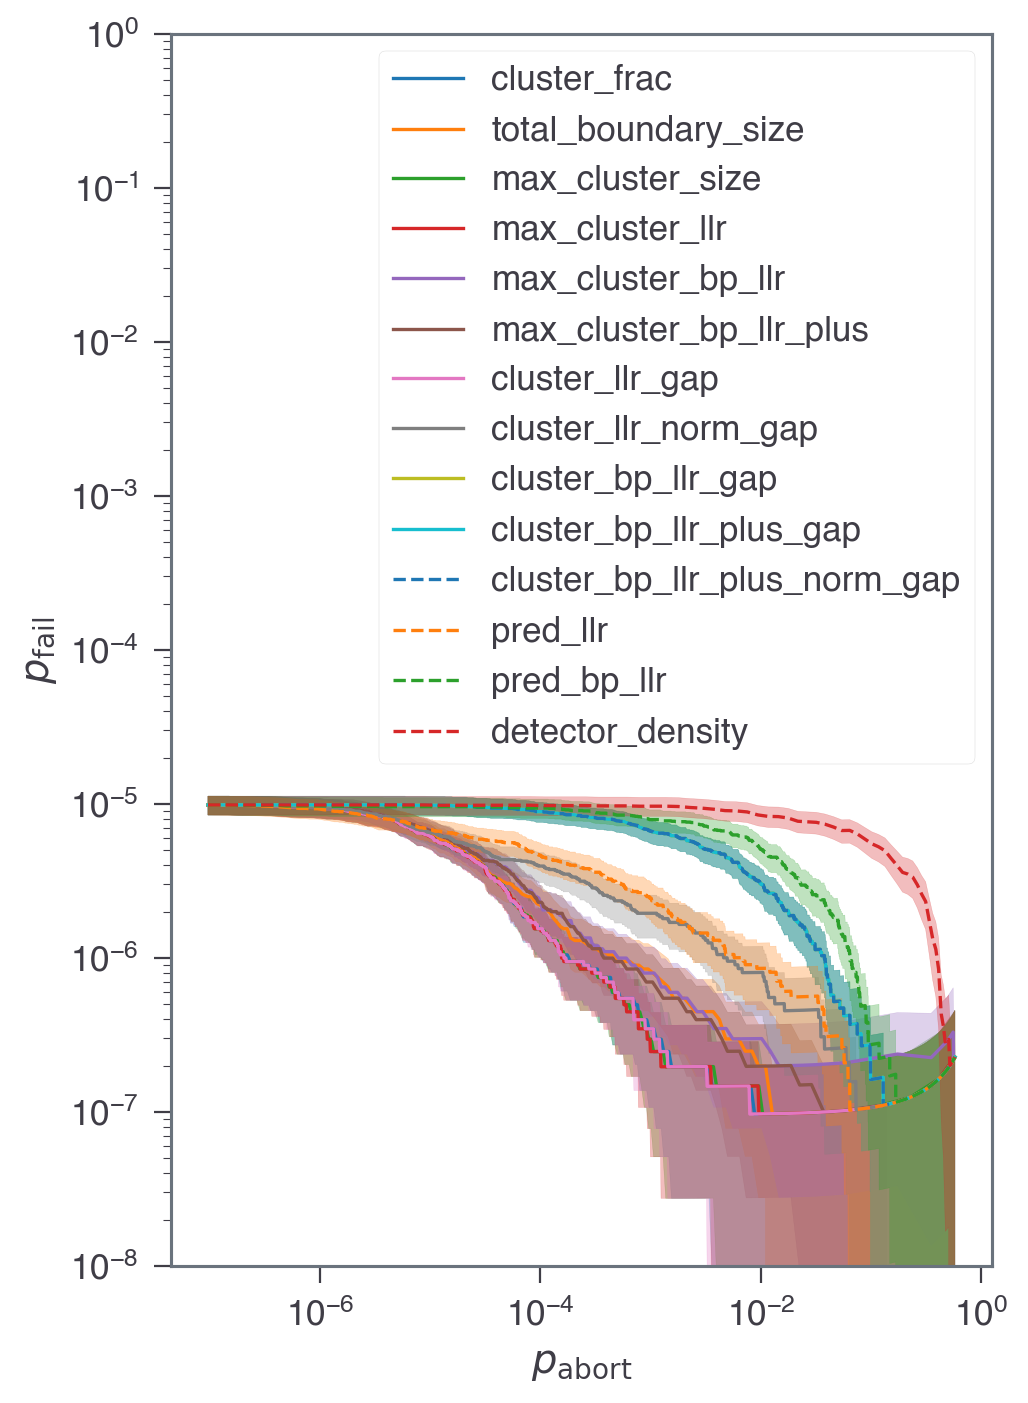

In [12]:
fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 8))

i = 0
for by, df_ps in df_ps_dict.items():
    error_band_plot(
        df_ps,
        "p_abort_conv",
        "p_fail_conv",
        "delta_p_fail_conv",
        color=COLORS(i % 10),
        linestyle="-" if i < 10 else "--",
        label=by,
        ax=ax,
    )
    i += 1

ax.set_xscale("log")
# plt.xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-8, 1)

ax.set_xlabel(r"$p_\mathrm{abort}$")
ax.set_ylabel(r"$p_\mathrm{fail}$")

fig.tight_layout()

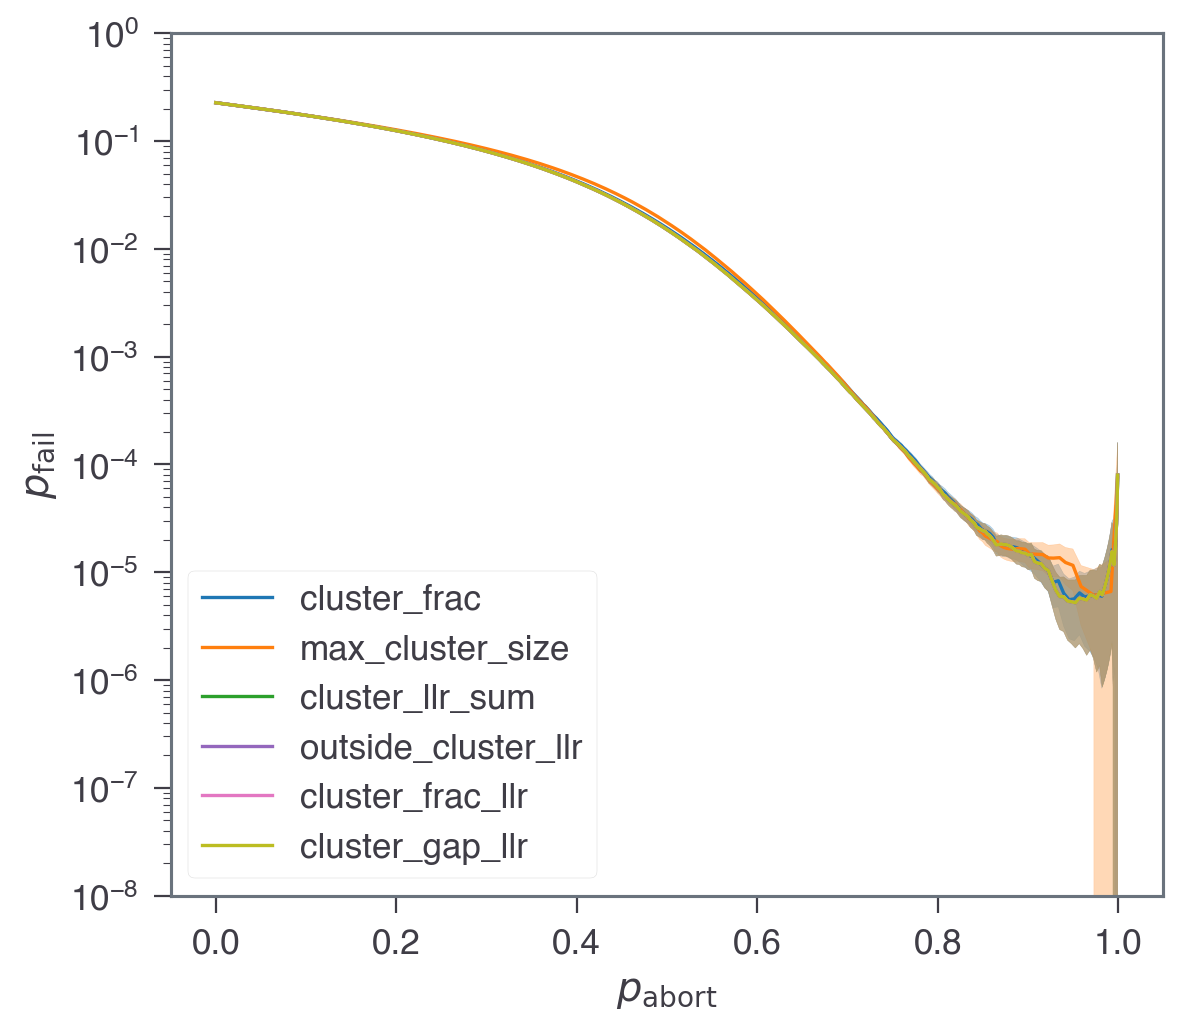

In [17]:
i = 0
for by, df_ps in df_ps_dict.items():
    if by in ["cluster_num"]:
        continue
    if by in [
        "pred_llr",
        "cluster_bp_llr_sum",
        "cluster_frac_bp_llr",
        "outside_cluster_bp_llr",
        "pred_bp_llr",
        "cluster_gap_bp_llr",
    ]:
        i += 1
        continue
    error_band_plot(
        df_ps,
        "p_abort_conv",
        "p_fail_conv",
        "delta_p_fail_conv",
        color=COLORS(i % 10),
        linestyle="-" if i < 10 else "--",
        label=by,
    )
    i += 1

# plt.xscale("log")
# plt.xlim(0, 1)
plt.yscale("log")
plt.legend()
plt.ylim(1e-8, 1)

plt.xlabel(r"$p_\mathrm{abort}$")
plt.ylabel(r"$p_\mathrm{fail}$")
plt.show()